# TP avec méthodes de Monte Carlo

[OpenAI gym](https://gym.openai.com/) est un environnement pour tester et comparer des algorithmes d'apprentissage par renforcement. 


## Black Jack (simplifié)

On considère une version simplifiée du jeu de Blackjack où le but est d'accumuler des cartes dont la somme des points ne doit pas dépasser 21. Les figures valent 10 points, les cartes numérotées valent le numéro de la carte. Il y a une complication avec l'as qui peut être vue comme valant 1 point (comme un 1) ou comme un 11 (un as). Ici, on va jouer contre un croupier qui a une stratégie fixée.
* au départ du jeu, le croupier et le joueur possèdent deux cartes. Le joueur peut observer ses deux cartes, mais ne peut observer qu'une seule carte du croupier.
* Si le joueur a déjà 21 points, la partie s'arrête et soit le joueur gagne, soit le match est nul si le croupier a aussi 21 points. 
* si le joueur n'a pas 21 points, il peut décider de rester (stick) ou bien il peut demander une nouvelle carte (hit) de façon répétée.
* quand le joueur décide de s'arrêter, le dealer peut à son tour s'arrêter ou demander des nouvelles cartes. Ici, on va supposer que ce choix se fait selon une stratégie fixe: il s'arrête dès qu'il a 17 point ou plus, il demande une carte dans le cas contraire.
* si un joueur dépasse 21 points en demandant une carte, il perd la partie
* si les deux joueurs se sont arrêtés, c'est celui dont la somme des cartes est plus proche de 21 qui remporte la partie.

On fait l'hypothèse que le croupier tire les cartes dans une pile infinie (avec remplacement).

Si le joueur possède un as qu'il peut utiliser comme 1 ou 11 sans dépasser 21, on dit qu'il a un as utilisable.

L'état du jeu peut être décrit par un triplet:
* la somme de points courante (dont on pourrait restreindre l'intervalle à [12-21])
* la valeur de la carte du croupier
* la possession ou non d'un as utilisable

On va donc modéliser avec un taux d'escompte $\gamma=1$.


In [ ]:
# import useful modules
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm import tqdm

# set up openAi Gym
import gym
from gym import envs
env = gym.make("Blackjack-v0")
numActions = env.action_space.n
print(env.observation_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))


L'état du jeu de blackjack est donc décrit par un triplet $(s_1, s_2, a)$ où $s_1$ est la somme des points contenus dans la main du joueur, $s_2$ est la valeur de la carte visible du croupier, et $a$ est un booléen qui indique si le joueur possède un as utilisable.

Comme vous pouvez le voir dans l'exécution du code ci-dessus, l'espace des états pour ce jeu est encodé comme un triplet, et $s_1$ peut prendre 32 valeurs, $s_2$ peut prendre 11 valeurs. En théorie, on pourrait restreindre $s_1$ a 21 valeurs (au delà de 21 points, on est dans un état final perdant), voir même moins (au deça de 10 points, prendre une carte est sans risque!). Pour faciliter le code, on ne va pas chercher à optimiser l'espace et on va conserver 32 possibilités. 

In [ ]:
# maxSum is the maximum sum I can have in my hand
maxSum = 32
# maxOppScore is the maximum value of the card I can see from the opponent
maxOppScore = 11
# number of States
numStates = 32*11*2
print('problem with ', numStates, " states and ", numActions, "actions")

problem with  704  states and  2 actions


  Pour essayer d'écrire un code que l'on pourra utiliser pour d'autres problèmes, on vous donne le code pour encoder l'état avec un entier et pour faire l'invese (i.e. décoder un entier en un état). Ainsi, il vous sera possible d'avoir des tables du style $v(s)$ et $q(s,a)$ où $s$ sera l'index d'un des états du jeu, et $a$ l'index d'une action....

In [ ]:
# function to encode or decode a state
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# encode a state as an integer
# for blackjack, the state is s=[i,j,b] where
# i is the number of points in my hand i \in [1,31]
# j is the number of points I can observe from the opponent j\in [1,10]
# b is a boolean telling whether I have a usable ace
#
# encode turns the state to an integer, and decode does the opposite
def encode(state):
  if state[2]:
    return state[0] + state[1]*maxSum
  else:
    return state[0]+ state[1]*maxSum + maxSum * maxOppScore

def decode(index):
  state = [0, 0, 0]
  if (index > maxSum*maxOppScore):
    state[2] = False
    index = index - maxSum*maxOppScore
  else:
    state[2] = True
  state[0] = index % maxSum
  state[1]= index // maxSum
  return state

## Evaluation d'une politique fixée

On va tout d'abord évaluer une politique fixée $\pi$ avec un algorithme de Monte Carlo. La politique que l'on va évaluer est simple: si le joueur à 20 points ou plus, il s'arrête, sinon, il demande une carte. La politique est encodée dans la fonction strategy ci-dessous.

In [ ]:
def strategy(state) :
  if (state[0] >= 20) :
    return 0
  else :
    return 1

### Implémentez

Implémentez l'algorithme de Monte Carlo dans sa version "all-visit" pour évaluer une politique (même si un état se répète plusieurs fois sur la trace d'exécution de l'épisode, on met à jour ses statistiques). Cet algorithme est un peu plus simple à implémenter que son variant "first-visit" pour lequel on met à jour un état seulement lors de sa première visite.

Cela dit, dans le cadre de Blackjack, est-ce qu'on aurait une différence?


Dans le cas du Blackjack , il n'y a de différence entre les résultats des versions "all-visit" et "première visite" car les états ne répètent jamais.

In [ ]:
def MonteCarlo_all_visit(nbEpisodes,policy, gamma):
    Vpi = np.zeros((numStates), dtype='float')
    acc = np.zeros((numStates), dtype='float')
    n = np.zeros((numStates), dtype='float')  

    cpt = 0
    # sum_of_rows = policy.sum(axis=1)
    # policy = policy / sum_of_rows[:, np.newaxis]  
    # print(policy)

    recompenses = []

    for episode in tqdm(range(nbEpisodes)):
        gameover = False
        visited = []

        # if cpt > 5000000*2/3:
        #   cpt = 0
        #   epsilon = max(0.15, epsilon/2)
        
        cpt+= 1
        #Tirer aléatoirement une paire (s0,a0)∈ S×A
        state = env.reset()
        s = encode(state)
        a = np.argmax(policy[s,:])
        visited.append(s)
        Gt = 0.0
        k = 0
        Gts = []
        while True:
            state,r,gameover,infos = env.step(a)  
            Gt = Gt + r*(gamma**k)  

            if gameover:
              break               

            # On suit la politique pi
            s = encode(state)
            a = np.argmax(policy[s,:])

            # Calcul du gain à long terme
            if not s in visited: 
              visited.append(s)                                                    
            
            k+=1
        recompenses.append(Gt)

        #Pour chaque paire (s, a) qui est visitée dans l’épisode
        for etat in visited:
            #Si la première occurrence de (s, a) est à l’instant t
            acc[etat] = acc[etat] + Gt
            n[etat] = n[etat] + 1
            Vpi[etat] = acc[etat]/n[etat]
    return Vpi,recompenses 



In [ ]:
#Generation de la politique à partir de la stratégie
policy_20 = np.zeros((numStates,2), dtype='float')
for i in range(maxSum):
  for j in range(maxOppScore):
      for k in [True, False]:
        index = encode([i,j,k])
        if i >= 20:
            policy_20[index,:] = [1,0]
        else:
            policy_20[index,:] = [0,1]

Ici, on va évaluer la statégie (arrêt si le joueur à plus de 20 pts) ave l'algorithme Monte Carlo "all visit" sur 1000000 d'épisodes. On cherche à évaluer $v_{\pi}$ à partir des épisodes en suivant la politique $\pi$.

In [ ]:
#Evaluation de la politique
Vpi_20,recompenses_20 = MonteCarlo_all_visit(nbEpisodes=1000000, policy=policy_20, gamma=1)

100%|██████████| 1000000/1000000 [01:34<00:00, 10621.16it/s]


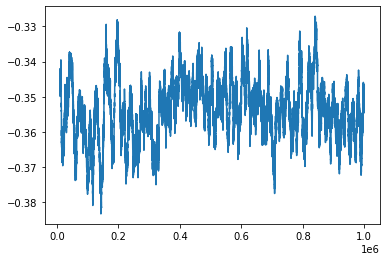

In [ ]:
recompenses_20 = pd.Series(recompenses_20)
recompenses_20_lissage = recompenses_20.rolling(window=10000).mean()

plt.plot(recompenses_20_lissage)

Les récompenses sont 1 en cas de victoire et -1 en cas de défaite et 0 en cas d'égalité. On remarque donc que cette stratégie n'est pas très efficace car la moyenne glissante des récompenses est négative, on perd donc plus souvent que l'on ne gagne. 

### Visualisez
Vous pouvez visualiser le résultat avec ce code qui affiche $v_\pi$.
Le code ci-dessous permet de faire un graphique en 2D où la couleur représente la fonction de valeur (plus la couleur est chaude, plus la valeur est haute).

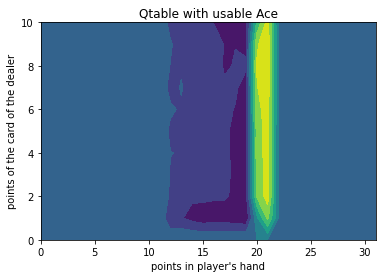

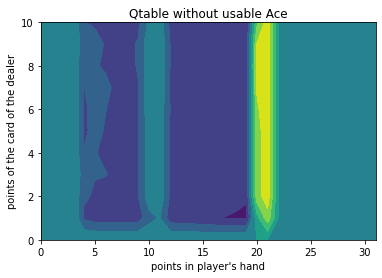

In [ ]:
x = np.arange(0,maxSum,1)
y = np.arange(0,maxOppScore,1)
# z1 for the states with usable ace
z1 = np.zeros((maxSum,maxOppScore))
# z2 for the states without usable ace
z2 = np.zeros((maxSum,maxOppScore))

for i in range(maxSum):
  for j in range(maxOppScore):
    index = encode([i,j,True])
    z1[i,j] =  Vpi_20[index]
    index = encode([i,j,False])
    z2[i,j] =  Vpi_20[index]

xx, yy = np.meshgrid(x,y)
h = plt.contourf(x,y,z1[:,:].T)
plt.title("Qtable with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
plt.show()
h = plt.contourf(x,y,z2[:,:].T)
plt.title("Qtable without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
plt.show()


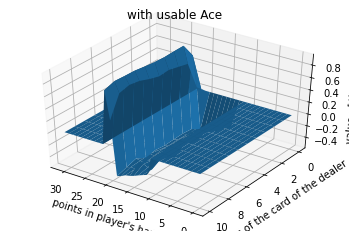

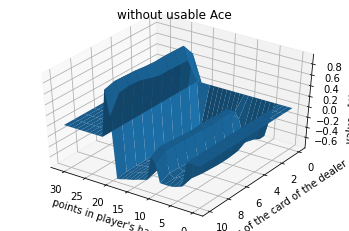

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z1[:,:].T)
ax.view_init(40,125)
plt.title("with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z2[:,:].T)
ax.view_init(40,125)
plt.title("without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

Les états après 21 ne sont jamais visités car la partie est terminée, le joueur ne peut pas recevoir de récompenses (positives ou négatives).

L'exemple du code ci-dessous permet de générer des graphiques en 3D pour visualiser la fonction $v$.

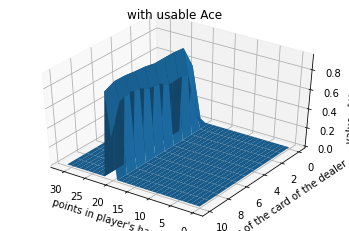

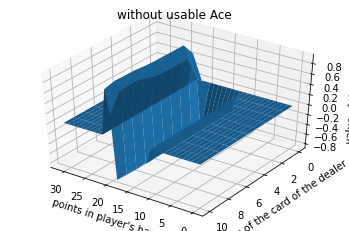

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z1[:,:].T)
ax.view_init(40,125)
plt.title("with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z2[:,:].T)
ax.view_init(40,125)
plt.title("without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

Dans le cas où on a pas d'as utilisable, on remarque que l'on a des valeurs de récompenses négatives quand on suit la politique $\pi$ et que le joueur a un peu moins de 20. En effet, dans ce cas le joueur continue à jouer et a une grande probabilité de dépasser 21 au prochain tour.

## Résolution: trouver une politique optimale

Avec les algorithmes "Value Iteration" ou "Policy Iteration", on aurait besoin de calculer la matrice de transition. Etant donné le nombre d'états, il serait probablement très fastidieux d'écrire cette matrice "à la main" ou bien d'écrire un programme pour calculer chaque probabilité exactement!

### Implémentez

Le but est d'implémenter l'algorithme Monte Carlo "on policy" pour trouver la politique optimale.

* Implémentez une fonction $draw(\pi)$
Implémentez une fonction $draw(\pi)$ qui prend en paramètre une distribution de probabilités sur les actions et qui tire une action au hasard en utilisant cette distribution
* Implémentez une méthode $epsGreedy(\epsilon, q)$ qui implémente $\epsilon$-glouton: 
  * avec une probabilité $\epsilon$, la méthode choisie une action de manière uniforme
  * avec une probabilité $1-\epsilon$, ma méthode choisie l'action qui a la plus grande valeur $q$. Si plusieurs actions ont la même valeur maximale $\max_i q(i)$, il serait bon d'en choisir une au hasard (au lieu peut-être de choisir toujours la première action qui a pour valeur $\max_i q(i)$).
* implémentez une fonction $onPolicyMC(numEpisodes, \gamma, \epsilon)$ qui implémente l'algorithme on policy Monte Carlo qui résoud de manière optimale un PDM. Votre fonction peut retourner la valeur des paires (action, etat). Les paramètres d'entrée sont 
    * numEpisodes: le nombre d'épisodes utilisés pour apprendre la politique optimale
    * $\gamma$ est le taux d'escompte: on veut optimiser $\displaystyle G_t = \sum_{k=0}^\infty \gamma^k r_{t+k+1}$
    * $\epsilon$ est le paramètre pour utiliser $\epsilon$-greedy pour l'exploration
* Une fois que vous avez terminé, visualisez la politique trouvée (vous pouvez écrire dans un tableau si vous continuez ou vous vous arrêtez selon la valeur de la carte du croupier et selon la valeur de votre main (ou utiliser des couleurs). Est-ce que cette politique vous parait correcte? En comparant avec la politique étudiée plus haut, donne-t-elle des meilleures valeurs?

Notez qu'il serait bon d'avoir une implémentation qui puisse être générale de façon à pouvoir utiliser votre code pour d'autres environnement. En particulier dans le jeu de blackjack, on utilise $\gamma=1$, mais cela pourrait être différent pour d'autres environnement.

Si vous rencontrez des difficultés pour coder, vous pouvez dans un premier temps faire un code spécifique qui fait l'hypothèse que $\gamma=1$, voir même que vous recevez un récompense non nulle lorsque vous atteignez un état terminal. L'implémentation de ce cas est plus simple.

In [ ]:
import random
# On fait l'hypothèse que pi est un vecteur numpy de taille le nombre d'actions disponible
def draw(pi):
  if np.all(pi == pi[0]):
    # Si toutes valeurs de politiques sont identiques, 
    # on choisit aléatoirement une action
    return np.random.choice(list(range(len(pi))))
  else:
    return np.random.choice(list(range(len(pi))), p=pi)

# Méthode espilon greedy
def epsGreedy(epsilon, q):
  res = np.random.binomial(1,epsilon)
  if res == 1:
    return np.random.binomial(1,0.5)
  else:
    all_same = np.all(q == q[0])
    if all_same:
      return np.random.binomial(1,0.5)
    else:
      return np.argmax(q)

L'algorithme on Policy MonteCarlo estime les valeurs d'une polique et l'améliore tout en l'utilisant pour générer les données. L'utilisation de cette méthode permet d'éviter la statégie "exploring starts" qui oblige à tirer alétoirement une paire (état,action) au début de chaque épisode. Nous avons utilisé la version "première visite" mais sachant que les états ne se répètent pas, il n'y pas de différence avec l'implémentation "all visit".

In [ ]:
def onPolicyMC(numEpisodes,numStates, gamma, epsilon):
    q = np.zeros((numStates,numActions), dtype='float')
    acc = np.zeros((numStates,numActions), dtype='float')
    n = np.zeros((numStates,numActions), dtype='float')  
    policy = np.zeros((numStates,numActions), dtype='float')

    cpt = 0
    # sum_of_rows = policy.sum(axis=1)
    # policy = policy / sum_of_rows[:, np.newaxis]  
    # print(policy)

    recompenses = []

    for episode in tqdm(range(numEpisodes)):
        gameover = False
        visited = []

        # if cpt > 5000000*2/3:
        #   cpt = 0
        #   epsilon = max(0.15, epsilon/2)
        
        cpt+= 1
        #Tirer aléatoirement une paire (s0,a0)∈ S×A
        state = env.reset()
        s = encode(state)
        a = draw(np.ones(numActions)/numActions)
        visited.append((s,a))
        Gt = 0.0
        k = 0
        Gts = []
        while True:
            state,r,gameover,infos = env.step(a)  
            Gt = Gt + r*(gamma**k)  

            if gameover:
              break               

            # On suit la politique pi
            s = encode(state)
            a = draw(policy[s,:])

            # Calcul du gain à long terme
            if not (s,a) in visited: 
              visited.append((s,a))                                                    
            
            k+=1
        recompenses.append(Gt)

        etats = set()
        #Pour chaque paire (s, a) qui est visitée dans l’épisode
        for (etat,action) in visited:
            #Si la première occurrence de (s, a) est à l’instant t
            acc[etat,action] = acc[etat,action] + Gt
            n[etat,action] = n[etat,action] + 1
            q[etat,action] = acc[etat,action]/n[etat,action]
            etats.add(etat)

        # Pour chaque état s dans l’épisode
        for etat in etats:
          a_opti = np.argmax(q[etat,:])
          for action in range(numActions):
              if action == a_opti:
                policy[etat,action] = 1 - epsilon + epsilon/numActions
              else:
                policy[etat,action] = epsilon/numActions   
    return policy, q, recompenses
    
policy,q,recompenses = onPolicyMC(numEpisodes=7000000,numStates = numStates, gamma=1, epsilon=0.2)

100%|██████████| 7000000/7000000 [16:01<00:00, 7278.96it/s]


In [ ]:
def visualize_policy(policy):
    x = np.arange(0,maxSum,1)
    y = np.arange(0,maxOppScore,1)
    # z1 for the states with usable ace
    z1 = np.zeros((maxSum,maxOppScore))
    p1 = np.zeros((maxSum,maxOppScore))
    # z2 for the states without usable ace
    z2 = np.zeros((maxSum,maxOppScore))
    p2 = np.zeros((maxSum,maxOppScore))

    for i in range(maxSum):
        for j in range(maxOppScore):
            index = encode([i,j,True])
            z1[i,j] =  policy[index,0]
            p1[i,j] =  np.argmax(policy[index,:])
            index = encode([i,j,False])
            z2[i,j] =  policy[index,0]
            p2[i,j] =  np.argmax(policy[index,:])

 
    xx, yy = np.meshgrid(x,y)
    h = plt.contourf(x,y,p1[:,:].T)
    plt.title("Policy with usable Ace")
    plt.xlabel("points in player's hand")
    plt.ylabel("points of the card of the dealer")
    plt.show()


    xx, yy = np.meshgrid(x,y)
    h = plt.contourf(x,y,p2[:,:].T)
    plt.title("Policy without usable Ace")
    plt.xlabel("points in player's hand")
    plt.ylabel("points of the card of the dealer")
    plt.show()

Les deux derniers graphiques montrent la politique en fonction du score du joueur et du dealer. En jaune, le joueur continue à jouer, en bleu le joueur s'arrête.

Dans le cas où on a un as utilisable, les états avant 11 ne sont jamais visitées.

Dans le cas où on n'a pas d'as utilisable, le joueur ne peut avoir qu'une paire de 2 au minimum. Les états avant 4 ne sont donc jamais visités. 
On remarque que la politique est interprétable et cohérente.

Quand le dealer a une carte faible, on s'arrêtera plus tôt de jouer (à 11) car on a l'avantage et continuer n'en vaut pas le risque.
A l'inverse, quand le dealer a une carte élevée (ici au dessus de 7), alors, on va continuer à jouer plus longtemps (jusqu'à 14 ou 15). De même quand le dealer a un as utilisable, on risque de perdre si notre score n'est pas suffisemment élevé, donc on prend le risque de jouer jusqu'à 16.






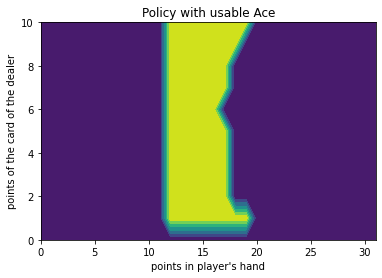

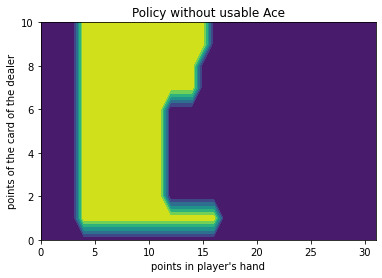

In [ ]:
visualize_policy(policy_1000000)

Ci-dessous, voici la politique obtenue après 2000000 itérations

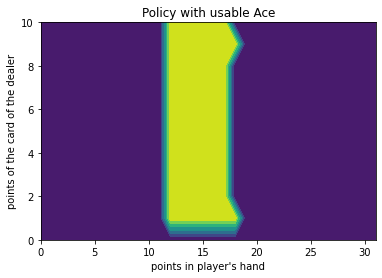

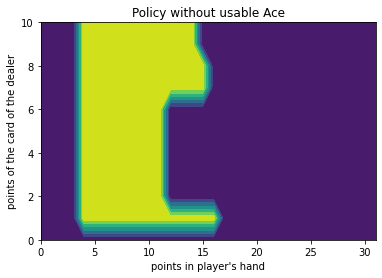

In [ ]:
visualize_policy(policy)

Voici maintenant l'évolution de la récompense moyenne pendant l'apprentissage avec l'algorithme Monte Carlo "on policy":

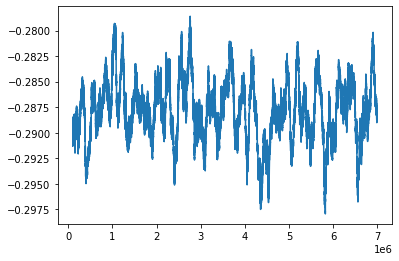

In [ ]:
recompenses = pd.Series(recompenses)
recompenses_lissage = recompenses.rolling(window=100000).mean()

plt.plot(recompenses_lissage)

A cette nouvelle politique, la récompense moyenne semble supérieur qu'avec la politique précédente.

Nous allons maintenant visualiser la table $Q$ et la politique : 

Ici, on utilise l'algorithme Monte Carlo "all visit" pour évaluer notre politique extraite (estimation de $v_{pi}$):

In [ ]:
Vpi_politique_optimale, recompenses_politique_optimale = MonteCarlo_all_visit(1000000, policy, gamma=1)


100%|██████████| 1000000/1000000 [01:26<00:00, 11511.62it/s]


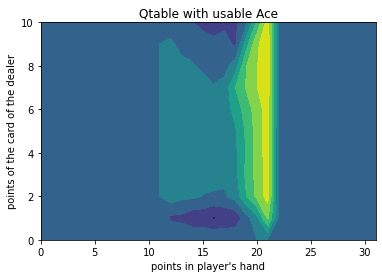

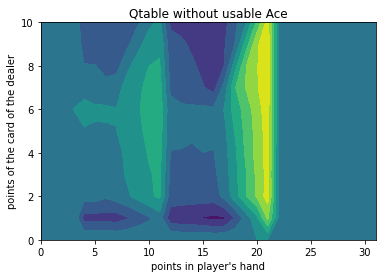

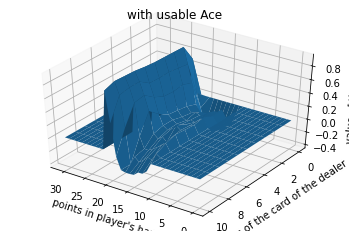

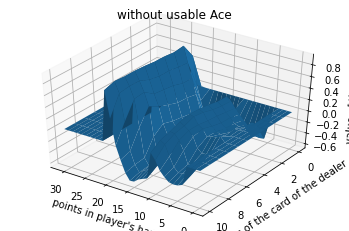

In [ ]:
x = np.arange(0,maxSum,1)
y = np.arange(0,maxOppScore,1)
# z1 for the states with usable ace
z1 = np.zeros((maxSum,maxOppScore))
# z2 for the states without usable ace
z2 = np.zeros((maxSum,maxOppScore))

for i in range(maxSum):
  for j in range(maxOppScore):
    index = encode([i,j,True])
    z1[i,j] =  Vpi_politique_optimale[index]
    index = encode([i,j,False])
    z2[i,j] =  Vpi_politique_optimale[index]

xx, yy = np.meshgrid(x,y)
h = plt.contourf(x,y,z1[:,:].T)
plt.title("Qtable with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
plt.show()
h = plt.contourf(x,y,z2[:,:].T)
plt.title("Qtable without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z1[:,:].T)
ax.view_init(40,125)
plt.title("with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z2[:,:].T)
ax.view_init(40,125)
plt.title("without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

Ci-dessus, nous avons affiché $v_{\pi}$ pour la nouvelle politique. On remarque l'on a des valeurs négatives



 Comparé à l'ancienne politique, on remarque que l'on a moins de valeurs négatives. Dans la section suivante, nous allons comparer la nouvelle politique avec l'ancienne.

Nous allons maintenant exploiter la politique (sans exploration) pour mesurer la récompense moyenne sur plusieurs épisodes

In [ ]:
#Exploitation de la politique
def exploitation_politique(numEpisodes, gamma, policy):
  # q = np.zeros((numStates,numActions), dtype='float')
  recompenses = []
  for episode in range(numEpisodes):
    gameover = False
    observation = env.reset()
    s = encode(observation)
    a = np.argmax(policy[s,:])
    Gt = 0.0
    k = 0
    while True:
      #Execution de l'action a et observation de r      
      observation, r, gameover, info = env.step(a)
      s_p = encode(observation)
      # Gt += Gt + r*gamma**k  
      # Si s_p est final
      if gameover:
        break      
      #On choisir une action a_p depuis s_p à partir
      #de la politique de q
      a_p = np.argmax(policy[s_p,:])
      s = s_p   
      a = a_p
      k+=1  
    
    recompenses.append(r)

  return recompenses

In [ ]:
recompenses_20 = exploitation_politique(2000,gamma=1,policy=policy_20)
recompenses_new_strategy = exploitation_politique(2000,gamma=1,policy=policy)
print("Récompenses moyenne de la polique (>20)", np.mean(recompenses_20))
print("Récompenses moyenne de la nouvelle politique (MC on policy)", np.mean(recompenses_new_strategy))


Récompenses moyenne de la polique (>20) -0.3605
Récompenses moyenne de la nouvelle politique (MC on policy) -0.06


A priori, la nouvelle politique permet d'obtenir une récompense moyenne supérieure à celle de la politique précédente (sur 2000 épisodes). Cependant, peut-on dire que la nouvelle politique est meilleure ? Pour répondre à cette question, il va falloir comparer les valeurs des politiques pour chaque état.

### Comparaison des politiques

En théorie, si $v_{\pi'}(s) \ge v_{\pi}(s)\forall s$ alors on peut dire que la politique $\pi'$ est meilleure que la politique $\pi$ ($\pi' ≽ \pi$). On va donc comparer pour chaque état $s$ les valeurs des 2 politiques. On va compter le nombre de fois où $v_{\pi'}(s) \ge v_{\pi}(s)$ sur le nombre d'états.

In [ ]:
cpt = 0
cpt_sup = 0
cpt_stric_sup = 0
for i in range(maxSum):
  for j in range(maxOppScore):
      for k in [True, False]:
        s = encode((i,j,k))
        cpt += 1
        if Vpi_politique_optimale[s] >= Vpi_20[s]:
          cpt_sup += 1

        if Vpi_politique_optimale[s] > Vpi_20[s]:
          cpt_stric_sup +=1

print(cpt_sup/cpt)
print(cpt_stric_sup/cpt)

0.9715909090909091
0.3693181818181818


Le résultat est que sur 97.15% des états, la nouvelle politique donne de meilleurs valeurs ou égales. On ne peut donc pas dire avec certitude que la nouvelle politique est meilleure que l'ancienne politique, cependant, la nouvelle politique fournit de meilleurs valeurs dans la grande majorité des cas.

Dans seulement 36.9% des cas, la nouvelle politique donne des valeurs de récompenses strictement supérieures à l'ancienne politique. Cela est dû au fait que dans la plupart des états, les valeurs de $v_{\pi'}(s)$ et $v_{\pi}(s)$ sont égales. On va donc maintentant compter le nombre de fois où $v_{\pi'}(s) > v_{\pi}(s)$ sur le nombre de fois où $v_{\pi'}(s) \neq v_{\pi}(s)$.

Ici, la majorité des cas

In [ ]:
cpt = 0
cpt_sup = 0
for i in range(maxSum):
  for j in range(maxOppScore):
      for k in [True, False]:
        s = encode((i,j,k))
        if not Vpi_politique_optimale[s] == Vpi_20[s]:
          cpt += 1
          if Vpi_politique_optimale[s] > Vpi_20[s]:
            cpt_sup += 1

print(cpt_sup/cpt)

0.9285714285714286


Ainsi, dans 92% des cas où $v_{\pi'}(s) \neq v_{\pi}(s)$, la nouvelle politique donne des valeurs strictement supérieures à l'ancienne.
Ce résultat combiné avec la comparaison des récompenses moyennes nous permet de conclure que la nouvelle politique apporte des améliorations. Cependant, d'un point de vue théorique, on ne peut pas dire que $\pi' ≻ \pi$.

Avec plus d'itérations, il serait en théorie possible de battre complétement l'ancienne politique.

#Algorithme Q-learning sur BlackJack

Nous allons maintenant utiliser l'algorithme off-policy Q-learning et $\epsilon$-greedy pour extraire une politique optimale pour le problème du BlackJack. Nous choisissons une décroissance par palier des paramètres ϵ et α.

In [ ]:
# Choix d'une action avec la méthode Epsilon Greedy
def epsGreedy(epsilon, q):
  res = np.random.binomial(1,epsilon)
  #quand le argmax n'est pas unique
  if res == 1:
    return np.random.randint(len(q))
  else:
    maxs = np.argwhere(q == np.max(q)).ravel()

    if len(maxs) > 1:
      return np.random.choice(maxs)
    else:
      return np.argmax(q)


def Q_learning(numEpisodes, gamma, alpha, epsilon, dec=False, start_dec=20000,tous_les=5000,tau_alpha=2, tau_epsilon=1.1):
  q = np.zeros((numStates,numActions), dtype='float')
  cpt = 0
  compteur_lance = False

  recompenses = []
  for episode in tqdm(range(numEpisodes)):


    gameover = False
    state = env.reset()
    s = encode(state)
    a = epsGreedy(epsilon, q[s,:])
    Gt = 0.0

    if compteur_lance :  
      cpt += 1

    # Décrément des valeurs de epsilon et du learning rate
    if dec:
      if episode > start_dec:
        compteur_lance = True
      if cpt > tous_les:
        cpt = 0
        alpha /= tau_alpha
        epsilon /= tau_epsilon


    while not gameover:
      observation_p, r, gameover, info  = env.step(a)
      s_p = encode(observation_p)
      Gt += r 

      # Si s_p est final
      if gameover:
        q[s,a] = q[s,a]+ alpha*(r-q[s,a])
        break

      correction = r + gamma*np.max(q[s_p,:]) - q[s,a]
      q[s,a] = q[s,a] + alpha*correction      

      a_p = epsGreedy(epsilon, q[s_p,:]) 
      s = s_p   
      a = a_p
    
    recompenses.append(Gt)

  return q,recompenses

In [ ]:
q_table_q_learning,recompenses_q_learning = Q_learning(8000000, 1, 0.04, 0.3,dec=True, start_dec=1000000,tous_les = 100000, tau_alpha=1.1, tau_epsilon=1.05)


100%|██████████| 8000000/8000000 [19:00<00:00, 7014.42it/s]


Ci-dessous, voici l'évolution de la récompense moyenne de la politique extraite avec Q-learning pendant l'apprentissage. On remarque que l'agent s'améliore tout au long de l'apprentssage.

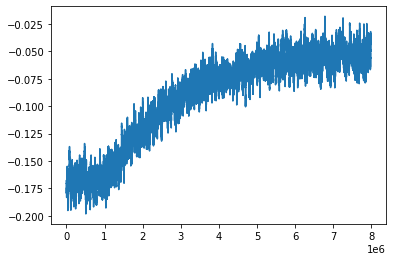

In [ ]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res

plt.plot(runningAvg(recompenses_q_learning,10000))


Ci-dessous, nous avons affiché la politique extraite avec l'algorithme off-policy Q-learning sur le problème du Blackjack.

On remarque que l'on converge bien vers une politique très similaire à celle obtenue avec Monte Carlo . Cela nous encourage sur le fait qu'il s'agisse bien de la politique optimale. 
Avec plus d'itérations, il serait possible d'avoir exactement les mêmes politiques pour Q-learning et Monte Carlo (une politique optimale).

On rappelle que nous n'avons pas de garantie de convergence avec Monte Carlo quand on utilise un seul épisode pour faire une amélioration sur la politique.

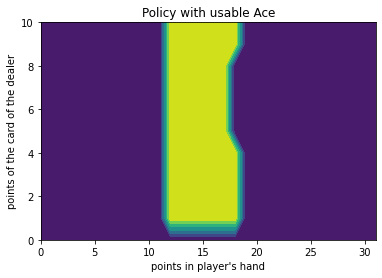

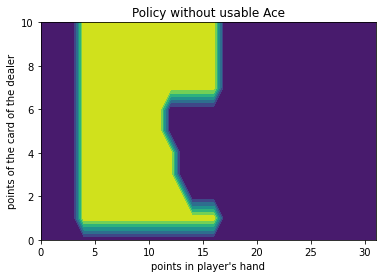

In [ ]:
visualize_policy(q_table_q_learning)


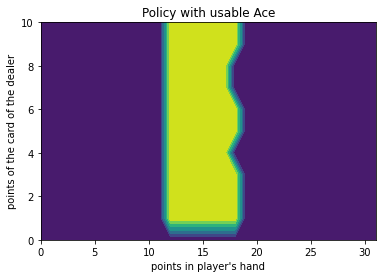

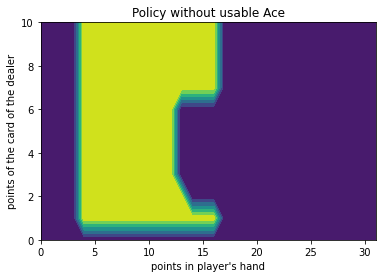

In [ ]:
visualize_policy(q_table_q_learning)

Nous allons maintenant comparer les résultats pour l'ancienne politique, celle obtenue avec MC on policy, et celle de Q-learning :

In [ ]:
print("Récompenses moyenne de la polique (>20)", np.mean(recompenses_20))

Récompenses moyenne de la polique (>20) -0.3605


In [ ]:
recompenses_q_learning = exploitation_politique(2000,gamma=1,policy=q_table_q_learning)
print("Récompenses moyenne de la polique obtenue avec Qlearning", np.mean(recompenses_q_learning))
print("Récompenses moyenne de la nouvelle politique (MC on policy)", np.mean(recompenses_new_strategy))

Récompenses moyenne de la polique obtenue avec Qlearning -0.077
Récompenses moyenne de la nouvelle politique (MC on policy) -0.091


En exploitant les politiques obtenues avec Q-learning et MC on policy, on obtient respectivement des récompenses moyennes de -0.077 et -0.091, donc proche de 0. Cela semble indiquer que l'on gagne environ 1 fois sur 2. Les récompenses moyennes avec cette politique sont supérieures à celles de l'ancienne politique (récompense moyenne à -0.36).

### Bonus
Vous pouvez tester votre code sur un autre environnement simple, par exemple frozen lake. Il existe plusieurs version de cet environnement, un avec une petite grille, un autre avec une grille plus grande.  On utilisera cet environnement dans le prochain TP.


In [ ]:
env = gym.make("FrozenLake-v0")
numActions = env.action_space.n
print("there are ", numActions, "actions")
print("observation space: ", env.observation_space)
numStates = env.observation_space.n
print("there are ", numStates, "states")

there are  4 actions
observation space:  Discrete(16)
there are  16 states


In [ ]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res
  
# visualisation de la table Q pour FrozenLake 4x4 et 8x8
# passez la taille (4 ou 8) en paramètres
def plotQ(q_table, map_size):
  if (map_size==4):
    MAP = [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
    ]
  else:
    MAP=[
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]
  best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
  best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
  fig, ax = plt.subplots()
  im = ax.imshow(best_value)

  for i in range(best_value.shape[0]):
      for j in range(best_value.shape[1]):
          if MAP[i][j] in 'GH':
              arrow = MAP[i][j]
          elif best_policy[i, j] == 0:
              arrow = '<'
          elif best_policy[i, j] == 1:
              arrow = 'v'
          elif best_policy[i, j] == 2:
              arrow = '>'
          elif best_policy[i, j] == 3:
              arrow = '^'
          if MAP[i][j] in 'S':
              arrow = 'S ' + arrow
          text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
  cbar = ax.figure.colorbar(im, ax = ax)
    
  fig.tight_layout()
  plt.show() 

#Exploitation de la politique
def exploitation_politique(numEpisodes, gamma, q):
  recompenses = []
  for episode in range(numEpisodes):
    gameover = False
    state = env.reset()
    s = state
    a = np.argmax(q[s,:])
    Gt = 0.0
    k = 0

    while True:
      #Execution de l'action a et observation de la récompense immédiate r      
      s, r, gameover, info = env.step(a)
      Gt += r 

      if gameover:
      # Episode terminée
        break
      
      #Exploitation de la politique
      a = np.argmax(q[s,:])
      k+=1  

    recompenses.append(Gt)

  return recompenses

Ci-dessous nous allons reprendre le même code que précedemment pour "on policy" Monte Carlo, cependant nous retirons la partie concernant l'encodage qui n'est plus nécessaire ici.

In [ ]:
def onPolicyMC(numEpisodes,numStates, gamma, epsilon):
    q = np.zeros((numStates,numActions), dtype='float')
    acc = np.zeros((numStates,numActions), dtype='float')
    n = np.zeros((numStates,numActions), dtype='float')  
    policy = np.zeros((numStates,numActions), dtype='float')

    # sum_of_rows = policy.sum(axis=1)
    # policy = policy / sum_of_rows[:, np.newaxis]  
    # print(policy)

    recompenses = []

    for episode in tqdm(range(numEpisodes)):
        gameover = False
        visited = []

        s = env.reset()
        a = draw(policy[s,:])
        visited.append((s,a))
        Gt = 0.0
        k = 0
        Gts = []
        while True:
            s,r,gameover,infos = env.step(a)  
            Gt = Gt + r*(gamma**k)
            if gameover:
              break

            # On suit la politique pi
            a = draw(policy[s,:])

            # Calcul du gain à long terme
            if not (s,a) in visited: 
              visited.append((s,a))
                        
            
            k+=1
        recompenses.append(Gt)

        etats = set()
        for (etat,action) in visited:
            acc[etat,action] = acc[etat,action] + Gt
            n[etat,action] = n[etat,action] + 1
            q[etat,action] = acc[etat,action]/n[etat,action]
            etats.add(etat)
        
        for etat in etats:
          a_opti = np.argmax(q[etat,:])
          for action in range(numActions):
              if action == a_opti:
                policy[etat,action] = 1 - epsilon + epsilon/numActions
              else:
                policy[etat,action] = epsilon/numActions   
    return policy, q, recompenses

policy_frozenlake,q_frozenlake,recompenses_frozenlake = onPolicyMC(numEpisodes=300000, numStates=numStates,gamma=1, epsilon=0.2)

100%|██████████| 300000/300000 [08:05<00:00, 617.50it/s]


Voici l'évolution de la récompense moyenne pendant l'apprentissage avec l'algorithme de Monte Carlo. On remarque que l'agent s'améliore pendant les premiers épisodes jusqu'à ce que la récompense moyenne semble stationnaire.

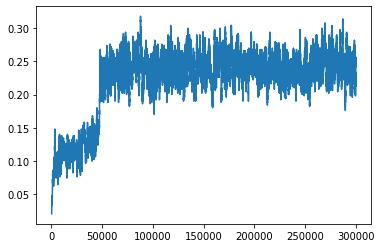

In [ ]:
recompenses_frozenlake = pd.Series(recompenses_frozenlake)
recompenses_frozenlake_lissage = recompenses_frozenlake.rolling(window=500).mean()

plt.plot(recompenses_frozenlake_lissage)

Avec l'algorithme Monte Carlo "on policy", en exploitant la politique sur 1000 épisodes, on arrive à atteindre l'objectif 78% du temps. Cela semble a priori un bon résultat lorsqu'on tient compte du facteur aléatoire intrinsèque au problème de frozenlake et la petite taille du plateau (4x4).

In [ ]:
recompenses_exploitation_frozenlake = exploitation_politique(1000, gamma=1, q=q_frozenlake)
print("Performances Monte Carlo (frozenlake):", np.mean(recompenses_exploitation_frozenlake))

Performances Monte Carlo (frozenlake): 0.785


Voici la visualisation de la politique dérivée de la table Q obtenue avec Monte Carlo "on policy" sur le problème frozenlake 4x4:

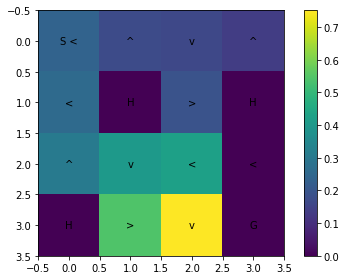

In [ ]:
plotQ(q_frozenlake, 4)
